Plant Classification Project - Marc David

In [1]:
!pip install kaggle

In [40]:
#import TensorFlow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import glob
import os
import cv2
from tensorflow.keras.preprocessing import image
import zipfile
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Connecting my Google Drive to access my Kaggle API token.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Create a directory for the Kaggle API token
!mkdir -p ~/.kaggle

# Copy the kaggle.json file from Google Drive to the Kaggle API directory
!cp '/content/drive/MyDrive/ML/kaggle.json' ~/.kaggle/

# Change permissions to secure the API token
!chmod 600 ~/.kaggle/kaggle.json

from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
# Authenticate API using the uploaded kaggle.json token
api = KaggleApi()
api.authenticate()

Preparing the data set.

In [7]:
api.dataset_download_files('yudhaislamisulistya/plants-type-datasets', path='/content/')

with zipfile.ZipFile('/content/plants-type-datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [8]:
dataset = '/content/dataset_type_of_plants_new'
files=glob.glob(dataset + '/**/*.jpg', recursive=True)

In [9]:
length = len(files)
print(files[length-1])
print(length)

/content/dataset_type_of_plants_new/aloevera/aloevera274.jpg
30000


In [10]:
classes = sorted(os.listdir(dataset)) #list of classes  #removing '.DS_Store' from classes list
numclass = len(classes)

Pre-processing data

In [11]:
tf.data.Dataset.list_files
data = tf.keras.utils.image_dataset_from_directory('dataset_type_of_plants_new')

Found 30000 files belonging to 30 classes.


In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30000 files belonging to 30 classes.
Using 24000 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30000 files belonging to 30 classes.
Using 6000 files for validation.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardizing data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


Making the Sequential Keras model

In [26]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(numclass, activation='sigmoid')
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

Early stop for regularization (to prevent overfitting).

In [29]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [30]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[earlystop]
)

Epoch 1/20
750/750 [==============================] - 30s 38ms/step - loss: 3.0071 - accuracy: 0.1292 - val_loss: 2.4605 - val_accuracy: 0.2968
Epoch 2/20
750/750 [==============================] - 26s 34ms/step - loss: 2.4232 - accuracy: 0.2813 - val_loss: 1.9757 - val_accuracy: 0.4222
Epoch 3/20
750/750 [==============================] - 26s 34ms/step - loss: 2.0602 - accuracy: 0.3808 - val_loss: 1.7610 - val_accuracy: 0.4835
Epoch 4/20
750/750 [==============================] - 26s 34ms/step - loss: 1.7068 - accuracy: 0.4729 - val_loss: 1.4944 - val_accuracy: 0.5550
Epoch 5/20
750/750 [==============================] - 26s 34ms/step - loss: 1.4027 - accuracy: 0.5504 - val_loss: 1.2832 - val_accuracy: 0.6293
Epoch 6/20
750/750 [==============================] - 26s 34ms/step - loss: 1.1627 - accuracy: 0.6207 - val_loss: 1.1578 - val_accuracy: 0.6760
Epoch 7/20
750/750 [==============================] - 26s 35ms/step - loss: 0.9859 - accuracy: 0.6696 - val_loss: 1.0774 - val_accuracy:

Visualize training results

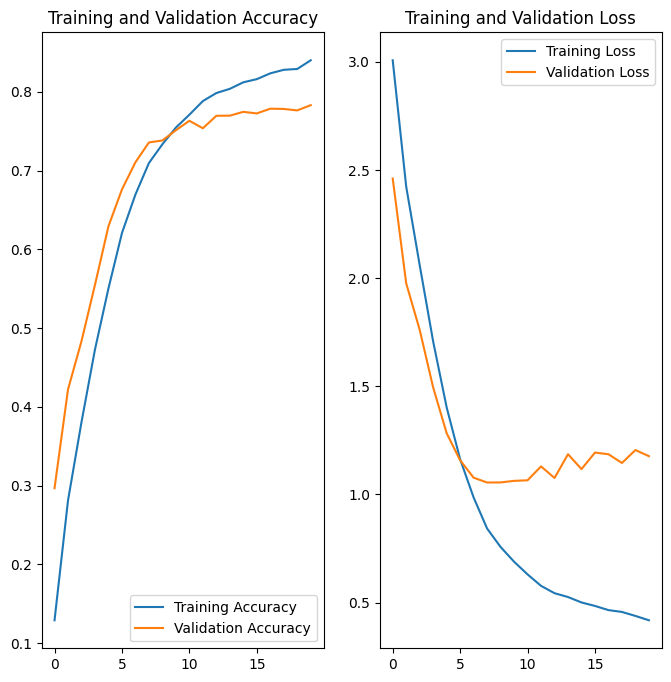

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing the model with a random image

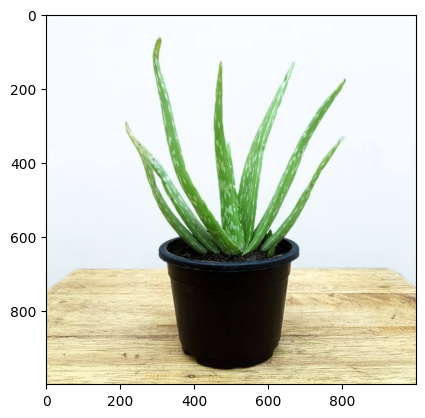

In [42]:
img = cv2.imread('/content/drive/MyDrive/ML/test.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
resize = tf.image.resize(img,(img_height, img_width))

In [51]:
img_array = tf.keras.utils.img_to_array(resize)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to aloevera with a 8.56 percent confidence.


Saving my model to the drive.

In [52]:
model_directory = '/content/drive/MyDrive/ML'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model to the specified directory
model.save(os.path.join(model_directory, 'plantclassification.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
